In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import julia
from julia import DynamicalSystems
from julia import Base
from julia import Main

%load_ext julia.magic

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Initializing Julia interpreter. This may take some time...


In [2]:
class linear_module_up(layers.Layer):
    
    def __init__(self, bias):
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )
        
        if bias == 1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
        
        else:
            self.b = tf.constant([0.,0.])

    def call(self, x):
        
        L = tf.concat([[[1., self.w]], [[0., 1.]]], 0)
        
        return tf.linalg.matvec(L,x) + self.b

class linear_module_low(layers.Layer):
    
    def __init__(self, bias):
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )
        
        if bias == 1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
        
        else:
            self.b = tf.constant([0.,0.])

    def call(self, x):
        
        L = tf.concat([[[1., 0.]], [[self.w, 1.]]], 0)
        
        return tf.linalg.matvec(L,x)


class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):        
        t = tf.concat([ [[0., self.w]], [[0.,0.]] ], 0)
        return x + tf.linalg.matvec(t, tf.math.sigmoid(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):        
        t = tf.concat([ [[0., 0.]], [[self.w, 0.]] ], 0)
        return x + tf.linalg.matvec(t, tf.math.sigmoid(x))

In [48]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
    
        super().__init__()
        
        
        self.Modules = []
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                
            else:
                self.Modules.append(activation_module_low())
                
            for j in range(N_sub):
                
                if j==(N_sub-1):
                    bias = 1
                else:
                    bias = 0
                
                if j%2==0:
                    self.Modules.append(linear_module_up(bias))

                else:
                    self.Modules.append(linear_module_low(bias))
 

    
    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
    
        return boom

In [49]:
def leapfrog(q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] - 0.5*Δt*mt.sin(q[-1]))
        q.append(q[-1] + Δt*p̄[-1])
        p.append(p̄[-1] - 0.5*Δt*mt.sin(q[-1]))
    
    X = []
    for i,j in zip(p,q):
        X.append([[i,j]])
    return X[0:len(X)-1], X[1:]

def leapfrog(q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] - 0.5*Δt*q[-1])
        q.append(q[-1] + Δt*p̄[-1])
        p.append(p̄[-1] - 0.5*Δt*q[-1])
    
    X = []
    for i,j in zip(p,q):
        X.append([[i,j]])
    return X[0:len(X)-1], X[1:]

def plot_true_tr(leapfrog, q0, p0, Δt, N):
    X = leapfrog(q0, p0, Δt, N)[0]
    q = []
    p = []
    for i in range(len(X)):
        q.append(X[i][0][0])
        p.append(X[i][0][1])
    plt.scatter(p, q)

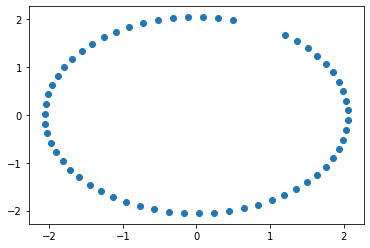

In [50]:
q0 = 1.2
p0 = 1.67
Δt = 0.1
N = 60


X = leapfrog(q0, p0, Δt, N)
plot_true_tr(leapfrog, q0, p0, Δt, N)

### Julia generated train dataset: Henon

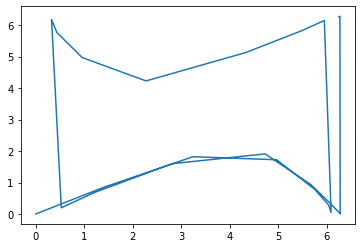

(TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))

In [140]:
%julia T = 30
%julia ds = DynamicalSystems.Systems.standardmap([0.001245, 0.00875]; k = 0.971635)
%julia q = DynamicalSystems.Systems.trajectory(ds, T)[:,1];
%julia p = DynamicalSystems.Systems.trajectory(ds, T)[:,2];

q = Main.q.tolist()
p = Main.p.tolist()

#plt.plot(q)
plt.plot(q,p)
plt.show()

X = []
for i in zip(p, q):
    X.append([[i[0], i[1]]])

x_train = np.array(X[:len(X)-1])
x_train = x_train.astype(np.float32)

y_train = np.array(X[1:])
y_train = y_train.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.batch(101)

train_dataset.element_spec

In [139]:
x_train = np.array(X[0])
x_train = x_train.astype(np.float32)

y_train = np.array(X[1])
y_train = y_train.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.batch(N)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

In [141]:
model = SympNet(8,5)

In [151]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.0005),
    metrics=["accuracy"],
)

In [152]:
start_time = time.time()
history = model.fit(train_dataset, epochs=10000, verbose=0);
print("running time : %s seconds" % (time.time() - start_time))

running time : 151.776793718338 seconds


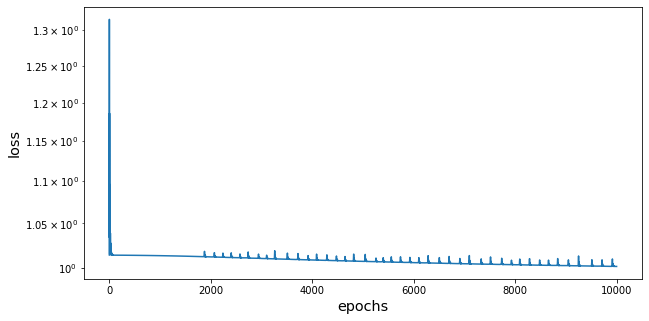

In [153]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel("epochs", fontsize = "x-large")
plt.ylabel("loss", fontsize = "x-large")
plt.yscale("log")

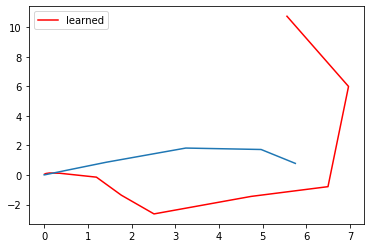

In [154]:
N_test = 10
p_l = [model(x_train[0])[0][0]]
q_l = [model(x_train[0])[0][1]]

run = [model(x_train[0][0])]
for i in range(N_test):
    run.append(model(run[-1]))
    p_l.append(run[-1][0])
    q_l.append(run[-1][1])

#plot_true_tr(leapfrog, q0, p0, Δt, N_test)
plt.plot(q_l, p_l, color = "r", label = "learned")
plt.plot(q[0:N_test], p[0:N_test])
plt.legend()
plt.show()